In this problem, you will work with 2,924,163 beer reviews from https://www.ratebeer. com. One entry contains the text of the consumer’s review together with ratings of appearance, aroma, palate, style, taste, and an overall score from 0 to 20. The data also include the name, id and brewer of the beer. You will give reviews binary label: 1 for a positive review with overall score at least 14, and 0 for a negative review.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import string
from collections import Counter
from PIL import Image
from operator import add
import json
import re
from scipy.sparse import coo_matrix

spark = SparkSession.builder.master('local[16]').appName('beer').getOrCreate()

# Part 1: Data inspection.

In [2]:
#load data
raw_df = spark.read.json("/project/cmsc25025/beer_review/labeled.json")
raw_df.show(2)

+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|overall|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   3.0|On tap at the Spr...|        0|   17|  6.0|
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   4.0|On tap at the Joh...|        1|   17|  7.0|
+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
only showing top 2 rows



In [3]:
#check the mean, median and standard deviation of the overall ratings for each beer and brewer

#map all reviews to (beer_name, brewer_id, overall_rating, 1)
rating_df = raw_df.rdd.map(lambda x: (x['beer_name'], x['brewer'], x['overall'], 1))
print "rating_df:", rating_df.take(1)

#reduce byBrewer to (brewer_id, [sorted_list_of_ratings])
rating_df_byBrewer = rating_df.map(lambda x: (x[1],[x[2]])).reduceByKey(add).map(lambda x: (x[0],sorted(x[1])))
print "rating_df_byBrewer:", rating_df_byBrewer.take(1)

rating_df: [(u'John Harvards Simcoe IPA', 3084, 13.0, 1)]
rating_df_byBrewer: [(0, [1.0, 3.0, 4.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0

In [4]:
def std_gt_one(x):
    #compute stdev only if len(x) > 1
    if len(x) > 1:
        return np.std(x)
    else:
        return np.nan
# a=[]
# print std_gt_one(a)
# a=[1,2]
# print std_gt_one(a)

In [5]:
#map to (brewer_id, mean, std, median ratings)
rating_df_byBrewer = rating_df_byBrewer.map(lambda x: (x[0],np.mean(x[1]), std_gt_one(x[1]), np.median(x[1])))
print "rating_df_byBrewer:",rating_df_byBrewer.take(1)

rating_df_byBrewer: [(0, 12.836223506743737, 2.5432971325766625, 13.0)]


In [6]:
#map to (beer_id, mean, std, median ratings)
rating_df_byBeer = rating_df.map(lambda x: (x[0],[x[2]])).reduceByKey(add).map(lambda x: (x[0],sorted(x[1])))
rating_df_byBeer = rating_df_byBeer.map(lambda x: (x[0],np.mean(x[1]), std_gt_one(x[1]), np.median(x[1])))
print "rating_df_byBeer:",rating_df_byBeer.take(1)

rating_df_byBeer: [(u'Legend Red Ale', 14.666666666666666, 0.47140452079103168, 15.0)]


In [7]:
def histPlot(x,mytitle):
    #plot histogram of values (assume a list)
    x = np.array(x)
    x = x[~np.isnan(x)]
    n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)
    plt.xlabel('stdev of reviews')
    plt.ylabel('probability')
    plt.title(mytitle)
    plt.show()
    return plt

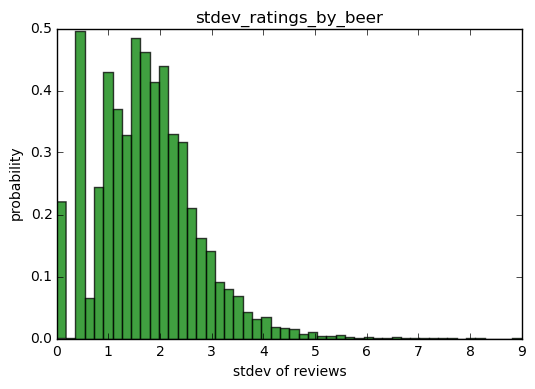

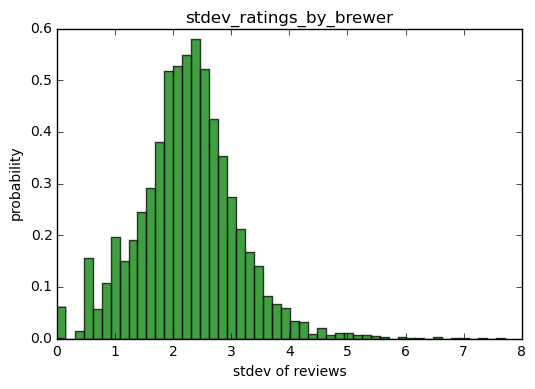

<module 'matplotlib.pyplot' from '/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [9]:
list_ratings_byBeer = rating_df_byBeer.map(lambda x: x[2]).collect()
histPlot(list_ratings_byBeer,'stdev_ratings_by_beer')
list_ratings_byBrewer = rating_df_byBrewer.map(lambda x: x[2]).collect()
histPlot(list_ratings_byBrewer,'stdev_ratings_by_brewer')

In [ ]:
#find max overall rating
print "max overall score:", raw_df.rdd.map(lambda x: x['overall']).max()

It looks like people are fairly consistent with their reviews for the same brewer and beer. The standard deviation of overall scores (max=20) is on avg about 2-3.

# Part 2: Sentiment analysis.

## (1) Generating features.

You need to represent text reviews in terms of a vector of features (covariates). One simple but effective representation is to use membership in a fixed vocab- ulary. Suppose the vocabulary contains p words. For a given review, you normalize the text, and separate it into space-delimited tokens. For each of the tokens, if it is in the dictionary you have a one for the corresponding word in the feature vector, and you ignore it otherwise.

In [3]:
with open('/project/cmsc25025/beer_review/vocab_50.json', 'r') as f:
         vocab = json.load(f)
#vocab is a dictionary: {word:id}. e.g., vocab['amazing']=573
#n, bins, patches = plt.hist(vocab.values(), 50, normed=1, facecolor='green', alpha=0.75)

In [4]:
print "vocab length:", len(vocab)
print "no. reviews: ", raw_df.count()

vocab length: 30009
no. reviews:  2486348


In [5]:
#go through reviews: 
#1. clean up text (keep words only); 
#2. map review to vocab --> a sparse.coo_matrix;
#3. filter out reviews w/o matches to vocab  

def cleanString(s):
    #s=re.split("[ ]",s)
    s.encode("utf-8")
    s = re.sub('([^A-Za-z]+)'," ",s.lower())
    return re.split("[ ]",s.encode("utf-8"))

def mapToMasterKeys(review, vocab):
    #map review to vocabulary as a sparse vector
    
    #make a counter to collapse review into a dictionary, exclude duplicates, etc.
    review = Counter(review)
    
    #all words in current review
    keys = review.viewkeys()
    
    #initialize vars for sparse vector construction
    row = np.zeros((len(keys)+1)) #len(keys)+1 includes intercept
    col = np.zeros((len(keys)+1))
    data = np.zeros((len(keys)+1))
    count=0
    
    #map words to master wordlist
    for key in keys:
        #get index of key in master vocab
        try:
            ix = vocab[key]
            #place 1 in ix position of vector
            col[count] = ix
            data[count] = 1
            count=count+1
        except KeyError:
            continue
    
    #add 1 to the last entry = intercept
    col[count] = len(keys)
    data[count] = 1
    row[count] = 0
    #forget about an intercept for now
    
    #return a sparse vector
    sparseVec = coo_matrix((data, (row, col)),(1,len(vocab)+1)) #len(vocab)+1 includes intercept
    return sparseVec

def binaryScore(x):
    if x>14:
        x=1
    else:
        x=0
    return x

In [6]:
#split data into training, dev, valid
train, dev, test = raw_df.rdd.randomSplit([70, 15, 15])

In [8]:
#represent review as a sparse feature vector
df_sparse_vec = train.map(lambda x: (x['review'],x['overall'])).\
                            map(lambda x: (mapToMasterKeys(cleanString(x[0]),vocab),binaryScore(x[1])))

In [9]:
print df_sparse_vec.take(1)

[(<1x30010 sparse matrix of type '<type 'numpy.float64'>'
	with 55 stored elements in COOrdinate format>, 0)]


In [10]:
#get avg [0,1] score
avg_score = df_sparse_vec.map(lambda x: x[1]).mean()
print 'avg 0-1 score is: ', avg_score

avg 0-1 score is:  0.389436990417


## (2) Stochastic gradient descent.

Your next job is to train an $l_2$-regularized logistic regression classifier using stochastic gradient descent. Recall the SGD framework that was covered in class: the reviews are coming in one by one and processed on the fly. As you process a review, update your model using the (stochastic) gradient computed on that review. We will use a variant algorithm called mini-batch SGD:

i. Initialize the model with $β = 0$ (uniform).

ii. Randomly split the training data into mini-batches. Make one pass of the data, processing
one mini-batch in every iteration. This is called one training epoch. 

iii. Repeat the last step a few times.

In [11]:
#initialize model with betas=0
beta = np.zeros((1,len(vocab)+1)) #len(vocab)+1 includes intercept

In [12]:
#split data into mini-batches
numrev = df_sparse_vec.count()
batchsize = 300*50
numbatches = int(float(numrev)/float(batchsize))

df_sparse_sample = []
# for i in np.arange(numbatches):
#     df_sparse_sample.append(df_sparse_vec.sample('False', float(batchsize)/float(numrev), seed=123).cache())
weights = [1 for i in range(numbatches)]
df_sparse_sample = df_sparse_vec.randomSplit(weights)
#df_sparse_sample[1].count() #= 32 in first batch
#df_sparse_sample[1].take(2)
#print weights

In [38]:
print df_sparse_sample[1].count()
print df_sparse_sample[2].count()

15092
14893


In [13]:
#cache all RDDs for faster evaluation
for i in range(len(df_sparse_sample)):
    df_sparse_sample[i].cache()

In [15]:
#helper functions to run SGD
import numpy as np
import time

def pi_log(beta,x):
    #logistic regression estimate of probability y=1/(1+exp(-beta*x)) and prediction of y (=yhat)
    yhat = (x.dot(beta.transpose())) 
    yhat = yhat[0][0] #dot product value is in [0][0] entry
    #print "yhat: ", yhat
    pi = float(1.0)/(float(1.0)+np.exp(-yhat))
    return pi, yhat

def update_beta(beta,eta,lam,x,y_min_pi):
    #update betas according to gradient with learning rate (=eta) and regularization (=lam)
    #pi, yhat = pi_log(beta,x) #pi=logistic regression estimate
    return beta + eta*((x.multiply(y_min_pi)).toarray() - lam*beta)

def eval_one_batch(beta0,eta,lam,myrdd):
    #run SGD on a single batch
    #assume myrdd has rows as ([sparse_vec_map2vocab],score), beta =[numpy_array_rowvec]
    
    #collect into a list for easier processing
    myrdd_list = myrdd.collect()
    #print "myrdd_list[0]: ", myrdd_list[0]
    
    beta = beta0 #initialize betas
    yerr=[] #store error in y
    yres=[] #store residual
    loglike=[] #store log likelihood
    
    for n in np.arange(len(myrdd_list)):
        x=myrdd_list[n][0]
        y=myrdd_list[n][1]
        pi, yhat = pi_log(beta,x)
        #print n, pi, yhat,(y-pi)
        
        #compute residual
        yres.append(y-pi)
        
        #compute error rate = is prediction right or wrong?
        if (y==1 and pi >= 0.5) or (y==0 and pi < 0.5): #got this right
            yerr.append(0) #error = 0
        else:
            yerr.append(1)
        beta = update_beta(beta,eta,lam,x,y-pi)
        
        #compute log likelihood = pi if y=1, (1-p) if y=0
        if (y==1):
            loglike.append(np.log(pi))
        else:
            loglike.append(np.log(float(1.0)-pi))
            
    return beta, yres, yerr, loglike

def validate(beta,myrdd_row):
    #test logistic prediction for one set of betas and one row of rdd
    #return prediction error for that row
    x=myrdd_row[0]
    y=myrdd_row[1]
    pi, yhat = pi_log(beta,x)
    
    yerr = []
    if (y==1 and pi >=0.5) or (y==0 and pi < 0.5): #got this right
        yerr = 0
    else:
        yerr = 1
    #print 'test yerr=', yerr
    #print 'test pi=', pi
    return yerr, pi, y
  
def eval_all(beta0,eta0,lam,all_rdd):
    #run one pass of SGD on all batches
    numbatches = len(all_rdd)
    #c1=0.02
    c1=eta0
    c2=0.5 #1 #0.5
    eta=eta0
    beta = beta0
    error_rate = []
    residuals = []
    sum_loglike = []
    for t in np.arange(numbatches):
        eta = c1/(t+1.0)**c2
        
        start = time.time()
        print "\n******** batch no. ", t, ', eta=', eta 
        
        myrdd = all_rdd[t]
        beta, yres, yerr, loglike = eval_one_batch(beta,eta,lam,myrdd)
        abs_error = sum(np.abs(yres))
        print 'sum_abs_res = ', abs_error, 'for batchsize=', len(yres), 'norm(beta): ', np.linalg.norm(beta)
        print 'no. wrong pred = ', sum(yerr), ', log(like)=', sum(loglike)
        print '********* took: ', time.time()-start, ' sec. to complete'
        
        error_rate.append(float(sum(yerr))/float(len(yres)))
        residuals.append(abs_error)
        sum_loglike.append(sum(loglike))
        
        #break out of loop if not making progress in SGD
        if t>5 and np.std(error_rate[-5:]) < 0.0005:
            print "---- SGD not making progress for past 5 batches! aborting SGD -----"
            break
    return error_rate, residuals, sum_loglike, beta
        
    

In [16]:
mybatch = df_sparse_sample[1]
beta0=beta
eta0=0.5
lam=0.005 #tested (below) values from 10^-4 to 10^3, looks like between 10e-2 and 10e-4 is best
#a,b=eval_one_batch(beta0,eta0,lam,mybatch)

In [17]:
print len(df_sparse_sample)

116


In [18]:
eta0=0.5
batch_start=1
batch_end=numbatches
error_rate, residuals, log_like, beta_fit = eval_all(beta0,eta0,lam,df_sparse_sample[batch_start:batch_end])


******** batch no.  0 , eta= 0.5
sum_abs_res =  5338.53757755 for batchsize= 14913 norm(beta):  14.1593623686
no. wrong pred =  4993 , log(like)= -13406.227425
********* took:  35.8120470047  sec. to complete

******** batch no.  1 , eta= 0.353553390593
sum_abs_res =  5404.53458701 for batchsize= 14888 norm(beta):  12.7700325482
no. wrong pred =  4943 , log(like)= -11745.8054928
********* took:  35.9446439743  sec. to complete

******** batch no.  2 , eta= 0.288675134595
sum_abs_res =  5368.3466309 for batchsize= 14894 norm(beta):  10.9733134079
no. wrong pred =  4737 , log(like)= -10687.566586
********* took:  36.525662899  sec. to complete

******** batch no.  3 , eta= 0.25
sum_abs_res =  5336.08067047 for batchsize= 14887 norm(beta):  10.3110347661
no. wrong pred =  4643 , log(like)= -9979.49378364
********* took:  36.3846812248  sec. to complete

******** batch no.  4 , eta= 0.22360679775
sum_abs_res =  5380.27762018 for batchsize= 15024 norm(beta):  9.60320056282
no. wrong pred =

In [19]:
#with eta0=0.1, c2=1 was at 3460 wrong after 20, at 3617 after 6
#with eta0=0.01 was at 3432 wrong after 6 batches, 3410 wrong in 9 batches
#with eta0=0.001 was at 3708 wrong in 6 batches
#with eta0=0.0001 was at 4163 wrong in 21 batches
print error_rate
print np.std(error_rate[-5:-1])

[0.334808556293167, 0.3320123589468028, 0.3180475359205049, 0.31188285080943107, 0.3078407880724175, 0.3071838111298482, 0.3060043080236941, 0.2965618926345419, 0.3014382740711147, 0.2969596827495043, 0.2942828485456369, 0.28904752462158767, 0.29634587070004015, 0.2952938800242375, 0.29155385326553523, 0.29039984032998467, 0.28455339153794496, 0.29236979683674147, 0.2878357864167382, 0.2875816993464052, 0.2849526855924297, 0.28123141970007265, 0.2886495112706962, 0.2822575328014769, 0.2790386289080806, 0.2798625614767904, 0.2900461878305107, 0.28436747793527684, 0.2768331910982735, 0.28070988676246605, 0.2813969106783076, 0.2730328192961645, 0.2807640750670241, 0.2798084704612894, 0.2825796985460851, 0.27640389842869456, 0.27997080873084323, 0.2739306858245194, 0.2789756518277715, 0.27999733652949793, 0.27299742455259857, 0.27499158532480644, 0.28019709681715277, 0.2764876632801161, 0.27850442594794556, 0.27808200881527984, 0.2692647158666576, 0.27064372550322197, 0.27390696745857457, 

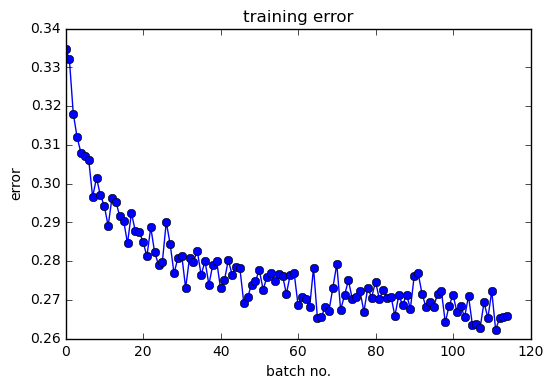

In [20]:
#plot training error as a fn of iteration
plt.plot(np.arange(len(error_rate)),error_rate,'o-')
plt.xlabel('batch no.')
plt.ylabel('error')
plt.title('training error')

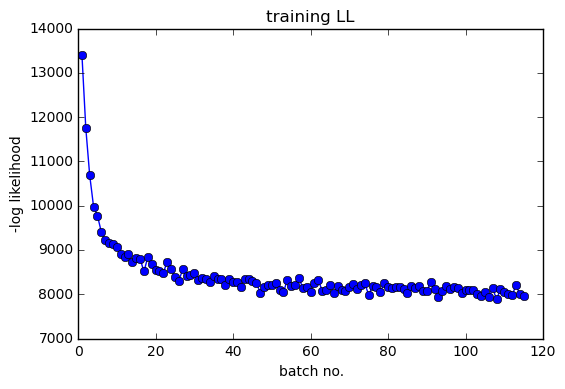

In [21]:
#plot negative log likelihood as a fn of iteration
plt.plot(np.arange(batch_start,batch_end),-np.array(log_like),'o-')
plt.xlabel('batch no.')
plt.ylabel('-log likelihood')
plt.title('training LL')

In [23]:
#get error rate on a new mini-batch for different lamdas
lamlist=10.0**np.array(np.arange(-4,3,1))

lam_err_rate = []
for lam in lamlist:
    print "trying lambda=", lam
    lam_beta_fit, lam_res, lam_err, loglike = eval_one_batch(beta_fit,eta0,lam,df_sparse_sample[batch_end-1])
    #print lam_err, lam_res, lam_beta_fit
    this_err_rate = float(sum(lam_err))/float(len(lam_res))
    lam_err_rate.append(this_err_rate)
    print this_err_rate

trying lambda= 0.0001
0.313081591369
trying lambda= 0.001
0.323668240054
trying lambda= 0.01
0.344504383007
trying lambda= 0.1
0.33809844909
trying lambda= 1.0
0.352933243425
trying lambda= 10.0


/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log
/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp
/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in log
/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in multiply
/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in add


0.98226567768
trying lambda= 100.0
0.993391773432


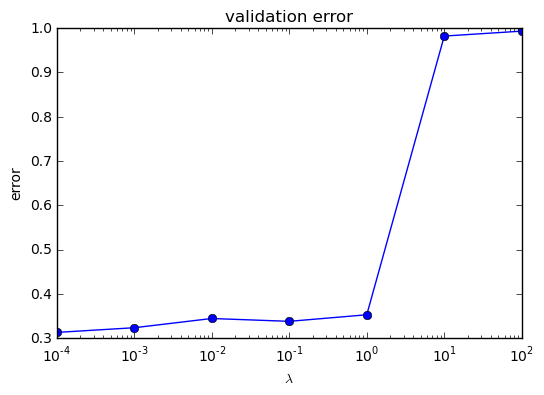

In [24]:
#plot validation error as a fn of lambdas
plt.semilogx(lamlist,lam_err_rate,'o-')
plt.xlabel(r'$\lambda$')
plt.ylabel('error')
plt.title('validation error')

In [20]:
print len(beta_fit[0])
#print beta_fit.transpose()

30009


In [25]:
#compute test error for last set of betas on entire testing set
#represent review as a sparse feature vector
df_test_sparse_vec = test.map(lambda x: (x['review'],x['overall'])).\
                            map(lambda x: (mapToMasterKeys(cleanString(x[0]),vocab),binaryScore(x[1]))).\
                            map(lambda x: validate(beta_fit,x)).cache()

In [26]:
print 'size of test dataset:', df_test_sparse_vec.count()
print 'test examples: (yerr, pi, y) '
print df_test_sparse_vec.take(5)

size of test dataset: 373686
test examples: (yerr, pi, y) 
[(0, 0.48512596387151008, 0), (0, 0.23690027700629815, 0), (0, 0.042145111892578691, 0), (0, 0.50512322139145804, 1), (0, 0.48344445149029225, 0)]


In [45]:
test_error = df_test_sparse_vec.map(lambda x: x[0]).mean()

In [46]:
print test_error

0.332512599031


The text-based logistic regression method attains a traing error of about 27% and testing error of about 33%.

## Part 3: Scores vs text.

In [44]:
#get mean and stdev for appearance, aroma, palate, style, taste
names = ['appearance', 'aroma','palate','style','taste']
means = dict([(i,0) for i in names])
stdevs = dict([(i,0) for i in names])

for name in names:
    means[name] = raw_df.rdd.map(lambda x: x[name]).mean()
    stdevs[name] = raw_df.rdd.map(lambda x: x[name]).stdev()
    
#normalize rdd
def binaryScore(x):
    if x>14:
        x=1
    else:
        x=0
    return x

def normRatings(x, names, means, stdevs):
    sort_names = sorted(names)
    #x = np.array(x[0]) #the list is stored as ([list]), so need to get [0] entry to get list
    #print x
    x = np.array(x)
    for i in np.arange(len(sort_names)):
        myname = sort_names[i]
        #print i,myname
        x[i] = (float(x[i])-float(means[myname]))/float(stdevs[myname])
    y = binaryScore(x[-1])
    #x = np.delete(x,-1)
    x[-1] = 1 # add intercept feature
    return x,y

In [45]:
#normalize reviews
norm_df = train.map(lambda x: (x['appearance'], x['aroma'], x['palate'],x['style'], x['taste'],x['overall'])).\
                    map(lambda x: normRatings(x,names,means,stdevs))


In [62]:
print norm_df.take(1)

[(array([ 0.6989573 , -0.21551798, -0.30980034, -0.94365614, -0.2781995 ,  1.        ]), 0)]


In [63]:
print norm_df.map(lambda x: x[1]).mean()

0.389436990417


In [46]:
#initialize model with betas=0
beta_scores = np.zeros((1,len(names)+1)) #+1 for intercept

#make batches out of training dataset
numrev = train.count()
batchsize = 300*50
numbatches = int(float(numrev)/float(batchsize))

In [47]:
gopal = np.array([1,2,3])
print gopal
gopal[-1] = 5
print gopal

[1 2 3]
[1 2 5]


In [48]:
weights = [1 for i in range(numbatches)]
train_sample = norm_df.randomSplit(weights)

In [50]:
# train_sample = []
# for i in np.arange(numbatches):
#     train_sample.append(norm_df.sample('False', float(batchsize)/float(numrev), seed=123))
train_sample[1].count() #= 299 in first batch
print train_sample[1].take(1)
print train_sample[2].take(1)

[(array([-0.53160626, -0.21551798, -0.30980034, -0.94365614, -0.89437284,  1.        ]), 0)]
[(array([-0.53160626,  0.3944758 , -0.30980034, -0.66257981, -0.2781995 ,  1.        ]), 0)]


In [58]:
#helper functions to run SGD
import numpy as np

def pi_log_scores(beta,x):
    #logistic regression estimate of probability y=1/(1+exp(-beta*x)) and prediction of y (=yhat)
    yhat = (x.dot(beta.transpose())) 
    #yhat = yhat[0][0] #dot product value is in [0][0] entry
    #print "yhat: ", yhat
    pi = float(1.0)/(float(1.0)+np.exp(-yhat))
    return pi, yhat

def update_beta_scores(beta,eta,lam,x,y_min_pi):
    #update betas according to gradient with learning rate (=eta) and regularization (=lam)
    #pi, yhat = pi_log(beta,x) #pi=logistic regression estimate
    return beta + eta*(x*(y_min_pi) - lam*beta)

def validate_scores(beta,myrdd_row):
    #test logistic prediction for one set of betas and one row of rdd
    #return prediction error for that row
    x=myrdd_row[0]
    y=myrdd_row[1]
    pi, yhat = pi_log_scores(beta,x)
    
    yerr = []
    if (y==1 and pi >=0.5) or (y==0 and pi < 0.5): #got this right
        yerr = 0
    else:
        yerr = 1
    #print 'test yerr=', yerr
    #print 'test pi=', pi
    return yerr, pi, y

def eval_one_batch_scores(beta0,eta,lam,myrdd):
    #run SGD on a single batch
    #assume myrdd has rows as ([sparse_vec_map2vocab],score), beta =[numpy_array_rowvec]
    
    #collect into a list for easier processing
    myrdd_list = myrdd.collect()
    #print "myrdd_list[0]: ", myrdd_list[0]
    
    beta = beta0 #initialize betas
    yerr=[] #store error in y
    yres=[] #store residual
    loglike=[] #store log likelihood
    
    for n in np.arange(len(myrdd_list)):
        x=myrdd_list[n][0]
        y=myrdd_list[n][1]
        #print x, y
        pi, yhat = pi_log_scores(beta,x)
        #print n, pi, yhat,(y-pi)
        
        #compute residual
        yres.append(y-pi)
        
        #compute error rate = is prediction right or wrong?
        if (y==1 and pi >= 0.5) or (y==0 and pi < 0.5): #got this right
            yerr.append(0) #error = 0
        else:
            yerr.append(1)
        beta = update_beta_scores(beta,eta,lam,x,y-pi)
        
        #compute log likelihood = pi if y=1, (1-p) if y=0
        if (y==1):
            loglike.append(np.log(pi))
        else:
            loglike.append(np.log(float(1.0)-pi))
            
    return beta, yres, yerr, loglike
  
def eval_all_scores(beta0,eta0,lam,all_rdd):
    #run one pass of SGD on all batches
    numbatches = len(all_rdd)
    c1=0.5 #0.02
    c2=0.5
    eta=eta0
    beta = beta0
    error_rate = []
    residuals = []
    sum_loglike = []
    for t in np.arange(numbatches):
        eta = c1/(t+1.0)**c2
        print "******** batch no. ", t, ', eta=', eta 
        
        myrdd = all_rdd[t]
        beta, yres, yerr, loglike = eval_one_batch_scores(beta,eta,lam,myrdd)
        abs_error = sum(np.abs(yres))
        print 'sum_abs_res = ', abs_error, 'for batchsize=', len(yres), 'norm(beta): ', np.linalg.norm(beta)
        print 'no. wrong pred = ', sum(yerr), ', log(like)=', sum(loglike) 
        error_rate.append(float(sum(yerr))/float(len(yres)))
        residuals.append(abs_error)
        sum_loglike.append(sum(loglike))
        
        #break out of loop if not making progress in SGD
        if t>5 and np.std(error_rate[-5:]) < 0.0005:
            print "---- SGD not making progress for past 5 batches! aborting SGD -----"
            break
        
    return error_rate, residuals, sum_loglike, beta

In [51]:
print train_sample[0].take(1)

[(array([ 0.6989573 ,  0.3944758 , -0.30980034,  0.93018611,  0.95414716,  1.        ]), 1)]


In [52]:
#parameters for SGD
beta0=beta_scores
eta0=0.5
lam=0.005

#previously plotted error rate for 1-35 batches ==> error rate remains between 26-27% for all batches
batch_start=1
batch_end=numbatches
error_rate, residuals, log_like, beta_fit = eval_all_scores(beta0,eta0,lam,train_sample[batch_start:batch_end])

******** batch no.  0 , eta= 0.5
sum_abs_res =  [ 3509.183026] for batchsize= 15106 norm(beta):  2.18677879387
no. wrong pred =  2837 , log(like)= [-6253.56644304]
******** batch no.  1 , eta= 0.353553390593
sum_abs_res =  [ 3473.16249062] for batchsize= 15182 norm(beta):  3.10494279584
no. wrong pred =  2614 , log(like)= [-5863.73203088]
******** batch no.  2 , eta= 0.288675134595
sum_abs_res =  [ 3471.19279982] for batchsize= 15058 norm(beta):  2.90944408936
no. wrong pred =  2610 , log(like)= [-5750.57714971]
******** batch no.  3 , eta= 0.25
sum_abs_res =  [ 3490.03223912] for batchsize= 14985 norm(beta):  2.06803357282
no. wrong pred =  2597 , log(like)= [-5715.57876759]
******** batch no.  4 , eta= 0.22360679775
sum_abs_res =  [ 3572.65417685] for batchsize= 15211 norm(beta):  2.5375472023
no. wrong pred =  2682 , log(like)= [-5757.29360687]
******** batch no.  5 , eta= 0.204124145232
sum_abs_res =  [ 3425.07406725] for batchsize= 14779 norm(beta):  2.32781197289
no. wrong pred =

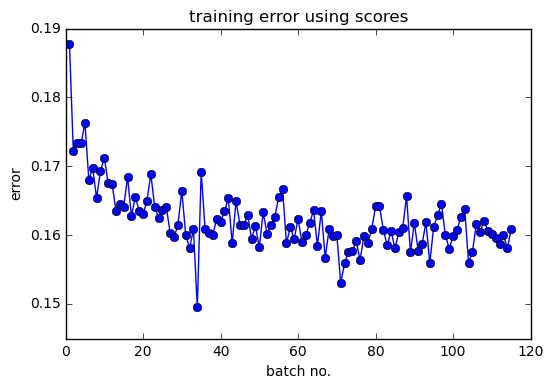

In [53]:
#plot training error as a fn of iteration
plt.plot(np.arange(batch_start,batch_end),error_rate,'o-')
plt.xlabel('batch no.')
plt.ylabel('error')
plt.title('training error using scores')

The training error of the scores-based analysis is much better! Let's see what happens when we use this model on the test set.

In [59]:
#compute test error for last set of betas on entire testing set
#represent review as a sparse feature vector
# df_test_sparse_vec = test.map(lambda x: (x['review'],x['overall'])).\
#                             map(lambda x: (mapToMasterKeys(cleanString(x[0]),vocab),binaryScore(x[1]))).\
#                             map(lambda x: validate(beta_fit,x)).cache()
        
#normalize reviews
test_scores_df = test.map(lambda x: (x['appearance'], x['aroma'], x['palate'],x['style'], x['taste'],x['overall'])).\
                    map(lambda x: normRatings(x,names,means,stdevs)).\
                    map(lambda x: validate_scores(beta_fit,x))

In [60]:
test_scores_error = test_scores_df.map(lambda x: x[0]).mean()

In [61]:
print test_scores_error

0.156842910893


The scores-based prediction seems to do a lot better on the test dataset as well: testing error of about 16% vs 28%. I'm guessing high scores on individual metrics are well correlated with the overall scores, so they are good predictors. Our text prediction method is much more crude, so either we didn't capture the most impactful words in determining the overall scores or perhaps we just cannot capture the oveall score with a linear combination of words, as we're trying to do in the text-based prediction above.

## Part 4. Contest.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import string
from collections import Counter
from PIL import Image
from operator import add
import json
import re
from scipy.sparse import coo_matrix
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

spark_contest = SparkSession.builder.appName('beer-svm').getOrCreate()

In [3]:
#load data
raw_df = spark_contest.read.json("/project/cmsc25025/beer_review/labeled.json")
raw_df.show(2)

+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|overall|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   3.0|On tap at the Spr...|        0|   17|  6.0|
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   4.0|On tap at the Joh...|        1|   17|  7.0|
+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
only showing top 2 rows



In [4]:
#get mean and stdev for appearance, aroma, palate, style, taste
names = ['appearance', 'aroma','palate','style','taste']
means = dict([(i,0) for i in names])
stdevs = dict([(i,0) for i in names])

for name in names:
    means[name] = raw_df.rdd.map(lambda x: x[name]).mean()
    stdevs[name] = raw_df.rdd.map(lambda x: x[name]).stdev()

In [5]:
#normalize rdd

#print means
#print stdevs

def binaryScore(x):
    if x>14:
        x=1
    else:
        x=0
    return x

def normRatings_LabeledPoint(x, names, means, stdevs):
    sort_names = sorted(names)
    #x = np.array(x[0]) #the list is stored as ([list]), so need to get [0] entry to get list
    #print x
    x = np.array(x)
    for i in np.arange(len(sort_names)):
        myname = sort_names[i]
        #print i,myname
        x[i] = (float(x[i])-float(means[myname]))/float(stdevs[myname])
    y = binaryScore(x[-1])
    x = np.delete(x,-1)
    lp = LabeledPoint(y,x)
    return lp

In [6]:
#normalize reviews and turn into labeled points
norm_lp_df = raw_df.rdd.map(lambda x: (x['appearance'], x['aroma'], x['palate'],x['style'], x['taste'],x['overall'])).\
                    map(lambda x: normRatings_LabeledPoint(x,names,means,stdevs))
train_svm, dev_svm, test_svm = norm_lp_df.randomSplit([70, 15, 15])

boo=train_svm.take(5)
print boo

[LabeledPoint(0.0, [0.698957295716,-0.215517980161,-0.309800335156,-0.943656144566,-0.278199503305]), LabeledPoint(0.0, [0.698957295716,-0.215517980161,0.895636057,-0.943656144566,0.337973829117]), LabeledPoint(0.0, [0.698957295716,-0.825511763502,-0.309800335156,-0.194119241001,-0.278199503305]), LabeledPoint(1.0, [1.92952085027,1.00446958652,0.895636057,0.97703217082,0.337973829117]), LabeledPoint(1.0, [0.698957295716,1.00446958652,-0.309800335156,-1.17788642693,0.337973829117])]


In [7]:
#make linear SVM model of reviews: from https://spark.apache.org/docs/2.1.0/mllib-linear-methods.html

#Build the model
model = SVMWithSGD.train(train_svm, iterations=200)

In [8]:
# Evaluating the model on training data
labelsAndPreds = train_svm.map(lambda p: (p.label, model.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(train_svm.count())
print("Training Error = " + str(trainErr))

Training Error = 0.210527343986


In [9]:
# Evaluating the model on testing data
test_labelsAndPreds = test_svm.map(lambda p: (p.label, model.predict(p.features)))
testErr = test_labelsAndPreds.filter(lambda (v, p): v != p).count() / float(test_svm.count())
print("Testing Error = " + str(testErr))

Testing Error = 0.211360318585


### Let's use this linear SVM to predict unlabeled data:

In [11]:
contest_df = spark_contest.read.json("/project/cmsc25025/beer_review/unlabeled.json")
contest_df.show(2)

+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
|       2.0|  4.0|  65957|John Harvards Fan...|  3084|   2.0|On tap at the Spr...|        4|   33|  4.0|
|       4.0|  5.0|  19708|John Harvards Dr....|  3084|   4.0|From Springfield ...|       12|   60|  7.0|
+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
only showing top 2 rows



In [12]:
#get mean and stdev for appearance, aroma, palate, style, taste
names = ['appearance', 'aroma','palate','style','taste']
contest_means = dict([(i,0) for i in names])
contest_stdevs = dict([(i,0) for i in names])

for name in names:
    contest_means[name] = contest_df.rdd.map(lambda x: x[name]).mean()
    contest_stdevs[name] = contest_df.rdd.map(lambda x: x[name]).stdev()

In [13]:
def normRatings_LabeledPoint_contest(x, names, means, stdevs):
    #return a normalized labeled point with a 'fake label' = (0, [norm_features])
    sort_names = sorted(names)
    #x = np.array(x[0]) #the list is stored as ([list]), so need to get [0] entry to get list
    #print x
    x = np.array(x)
    for i in np.arange(len(sort_names)):
        myname = sort_names[i]
        #print i,myname
        x[i] = (float(x[i])-float(contest_means[myname]))/float(contest_stdevs[myname])
    y = 0 #dummy label
    #print x
    lp = LabeledPoint(y,x)
    return lp

In [14]:
#normalize reviews and turn into labeled points (review_ID, LabeledPt(0,[features]))
contest_lp_df = contest_df.rdd.map(lambda x: (x['review_id'], x['appearance'], x['aroma'], x['palate'],x['style'], x['taste'])).\
                    map(lambda x: (x[0],normRatings_LabeledPoint_contest(x[1:],names,contest_means,contest_stdevs)))

In [15]:
boo = contest_lp_df.take(2)
print boo

goo = contest_df
#print boo[0][0]
#print boo[0][1].features[1:]

[(4, LabeledPoint(0.0, [-1.7635182412,-1.43786488311,-1.51521345166,-0.189867920231,-1.51252833445])), (12, LabeledPoint(0.0, [0.699209624944,-0.827382142143,0.892641047443,1.07555763827,0.336235799826]))]


In [16]:
# Predict beer ratings in contest using SVM
contest_pred = contest_lp_df.map(lambda p: (p[0], model.predict(p[1].features)))
all_predictions = contest_pred.collect()
print all_predictions[1:3]
all_predictions = dict(all_predictions)
#print dict(all_predictions)

[(12, 1), (19, 0)]


In [18]:
# save predictions to a file
TOSAVE=0
if TOSAVE==1:
    with open('assn3_prob4_predict.json', 'w') as f:
        json.dump(all_predictions, f)